In [151]:
import pandas as pd
import os
from matplotlib import pyplot
import matplotlib.colors as mcolors
import matplotlib
import math
from matplotlib.pyplot import figure
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
from google.cloud import storage
from google.cloud.storage import Blob

In [220]:
dir_files = [n.split('.')[0] for n in os.listdir('/home/jupyter/pss/tmp/') if not n in ['.ipynb_checkpoints', 'Untitled.ipynb', 'TMalign.cpp', 'blast_annotations.parquet']]
res = pd.DataFrame(None)
for file in dir_files:
    res = res.append(pd.read_parquet(f'/home/jupyter/pss/tmp/{file}.parquet'))
print(f'Experiment: {len(res):,.0f} out of 83,341 processed')

Experiment: 83,341 out of 83,341 processed


In [221]:
print('Highest number of processed protein pairs per cluster')
print(res[['cluster', 'target_protein']].groupby(['cluster']).count().reset_index().sort_values(by=['target_protein'], ascending=False)[:10])
print('\nHighest mean tmalign scores for processed pairs by cluster')
print(res[['cluster', 'tmalign_score']].groupby(['cluster']).mean(['tmalign_score']).reset_index().sort_values(by=['tmalign_score'], ascending=False)[:10])

Highest number of processed protein pairs per cluster
     cluster  target_protein
158      356           23298
92       213           11849
152      348            9470
110      260            2700
146      338            2155
68       149            1969
129      305            1852
151      347            1785
145      335            1633
32        69            1339

Highest mean tmalign scores for processed pairs by cluster
     cluster  tmalign_score
92       213       0.910618
74       159       0.830581
10        19       0.821782
54       108       0.819567
132      314       0.814147
13        24       0.756186
131      309       0.753960
102      233       0.749545
3         10       0.745261
98       222       0.724249


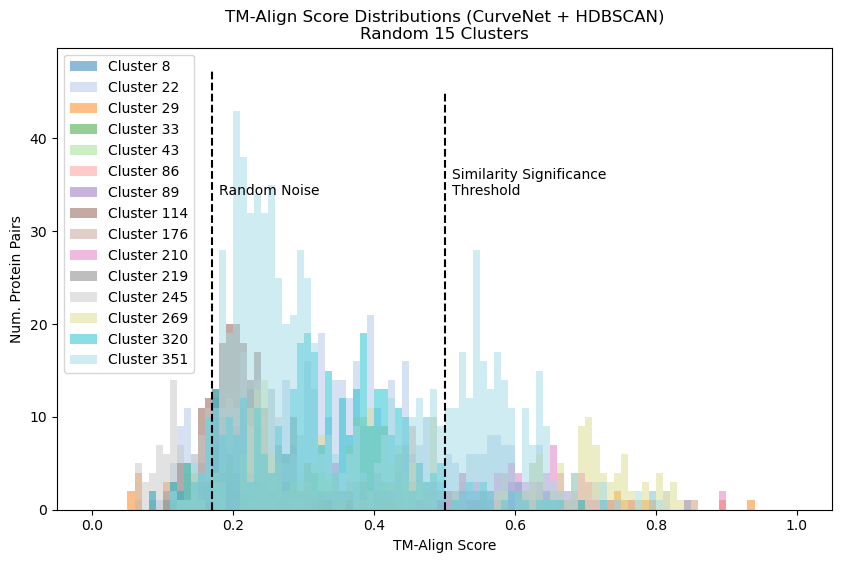

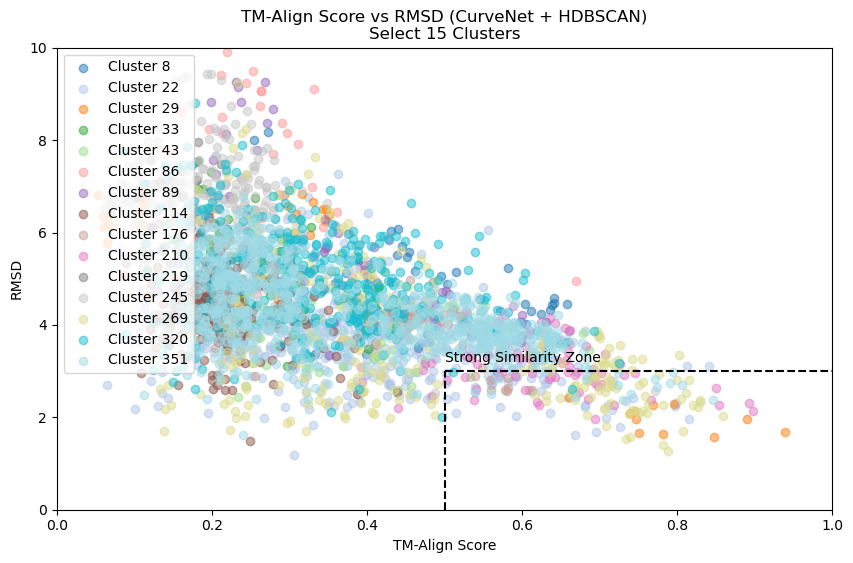

In [222]:
from utils import model_and_evaluate_cluster as ev

cmap = 'tab20'
name = f"CurveNet + HDBSCAN"

plot_1_clusters = ev.tmalign_hist(res, version='random', num_results=15, cmap=cmap, name=name)
plot_2_clusters = ev.tmalign_scatter(res[res.cluster.isin(plot_1_clusters)], cmap=cmap, name=name)

In [223]:
print(len(res))
res.head()

83341


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score,cluster
0,AF-A6NNF4-F1-model_v1,738,AF-Q9Y5A6-F1-model_v1,473,205,2.05,0.26618,356
1,AF-P08708-F1-model_v1,135,AF-Q9NZE8-F1-model_v1,188,52,4.40,0.23639,286
2,AF-Q9HBT7-F1-model_v1,761,AF-Q8NEK5-F1-model_v1,533,316,4.69,0.34774,356
3,AF-O75396-F1-model_v1,215,AF-O15155-F1-model_v1,118,63,2.90,0.25303,138
4,AF-Q6TDP4-F1-model_v1,642,AF-Q8N239-F1-model_v1,644,511,5.11,0.63594,87


In [224]:
batch_stats = pd.read_parquet('/home/jupyter/pss/pairwise_evaluation_metrics.parquet')
print(len(batch_stats))
batch_stats.head()

1069766


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q8N1S5-F1-model_v1,342,AF-P48449-F1-model_v1,732,190,7.43,0.30487
1,AF-Q8N1S5-F1-model_v1,342,AF-Q8N6C7-F1-model_v1,128,70,5.22,0.14206
2,AF-Q8N1S5-F1-model_v1,342,AF-Q9NW08-F1-model_v1,1133,156,6.86,0.26120
3,AF-Q8N1S5-F1-model_v1,342,AF-C9J3I9-F1-model_v1,102,48,3.15,0.12211
4,AF-Q8N1S5-F1-model_v1,342,AF-Q02930-F1-model_v1,508,123,6.88,0.20843


In [225]:
new_batch_stats = batch_stats.append(res.drop(['cluster'], axis=1))
print(len(new_batch_stats))
new_batch_stats.head()

1153107


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q8N1S5-F1-model_v1,342,AF-P48449-F1-model_v1,732,190,7.43,0.30487
1,AF-Q8N1S5-F1-model_v1,342,AF-Q8N6C7-F1-model_v1,128,70,5.22,0.14206
2,AF-Q8N1S5-F1-model_v1,342,AF-Q9NW08-F1-model_v1,1133,156,6.86,0.26120
3,AF-Q8N1S5-F1-model_v1,342,AF-C9J3I9-F1-model_v1,102,48,3.15,0.12211
4,AF-Q8N1S5-F1-model_v1,342,AF-Q02930-F1-model_v1,508,123,6.88,0.20843


In [226]:
new_batch_stats.drop_duplicates(inplace=True)
print(len(new_batch_stats))

1153107


In [227]:
table = pa.Table.from_pandas(new_batch_stats)
pq.write_table(table, f'/home/jupyter/pss/pairwise_evaluation_metrics.parquet')
len(pd.read_parquet('/home/jupyter/pss/pairwise_evaluation_metrics.parquet'))

1153107

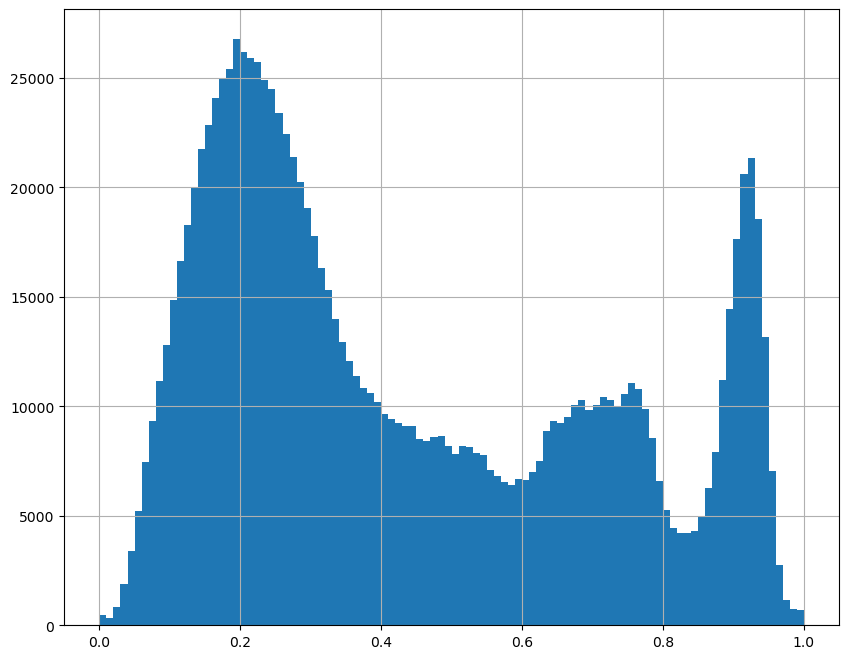

In [228]:
new_batch_stats.tmalign_score.hist(bins=100, figsize=(10,8));